In [1]:
import pandas as pd
import MyLib.nlp as nlp
import MyLib.HTML_prep as HTML_prep
import MyLib.analysis as analysis 
import MyLib.hype as hype 
from ipywidgets import interactive, interact

%load_ext autoreload
%autoreload 2

# 1. Import Files & group by date


In [ ]:
df.columns

In [51]:
df=pd.read_json("2023-07-30_ChatGPT_Sentences_NLP-Out_small.json")

In [46]:
df.head(5)

,Uni,FileKey,url,date,Title,linkName,linkUrl,AI_paragraphs,text_clean,letters_count,word_count,language,source_language,pure_text,Lemmata,NoStopwords
0,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,2023-01-01,Research projects - Communication Science,"[More information., Information Explosion, INt...",[https://www.ru.nl/communicationscience/@96084...,INtoEAT: Chatbot algorithms and coaching strat...,INtoEAT: Chatbot algorithms and coaching strat...,69,9,en,en,intoeat chatbot algorithms and coaching strate...,"[intoeat, chatbot, algorithm, and, coach, stra...","[intoeat, chatbot, algorithm, coach, strategy,..."
1,Radboud Nijmegen,QJ4WZUBB,https://www.ru.nl/communicationscience/researc...,2023-01-01,Research projects - Communication Science,"[More information., Information Explosion, INt...",[https://www.ru.nl/communicationscience/@96084...,Chatbot Usability - Studying the Impact of Cha...,Chatbot Usability - Studying the Impact of Cha...,106,16,en,en,chatbot usability studying the impact of chat...,"[chatbot, usability, study, the, impact, of, c...","[chatbot, usability, study, impact, chatbot, b..."
2,Radboud Nijmegen,K3P5X7U4,https://www.ru.nl/communicatiewetenschap/onder...,2023-01-01,INtoEAT: Chatbot algorithms and coaching strat...,[],[],INtoEAT: Chatbot algorithms and coaching strat...,INtoEAT: Chatbot algorithms and coaching strat...,94,11,en,en,intoeat chatbot algorithms and coaching strate...,"[intoeat, chatbot, algorithm, and, coach, stra...","[intoeat, chatbot, algorithm, coach, strategy,..."
3,Radboud Nijmegen,K3P5X7U4,https://www.ru.nl/communicatiewetenschap/onder...,2023-01-01,INtoEAT: Chatbot algorithms and coaching strat...,[],[],A healthy diet can help keep the body and mind...,A healthy diet can help keep the body and mind...,866,133,en,en,a healthy diet can help keep the body and mind...,"[a, healthy, diet, can, help, keep, the, body,...","[healthy, diet, help, body, mind, healthy, ext..."
4,Radboud Nijmegen,K3P5X7U4,https://www.ru.nl/communicatiewetenschap/onder...,2023-01-01,INtoEAT: Chatbot algorithms and coaching strat...,[],[],Research within the FSW and BSI combines insig...,esearch within the FSW and BSI combines insigh...,478,69,en,en,esearch within the fsw and bsi combines insigh...,"[esearch, within, the, fsw, and, bsi, combine,...","[esearch, fsw, bsi, combine, insight, social, ..."


In [84]:
freq="W"
#df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")

df_publ=df.drop_duplicates(subset="sentences")[["date","key"]]
df_publ=df_publ.set_index("date").groupby(pd.Grouper(freq=freq)).count()
df_publ.columns=["sentences"]
df_publ.tail()

,sentences
date,
2023-07-09,1444
2023-07-16,64
2023-07-23,43
2023-07-30,100
2023-08-06,873


In [67]:
df_publ

,sentences
date,
1999-01-03,20
1999-01-31,0
1999-02-28,0
1999-03-28,0
1999-04-25,0
...,...
2023-04-23,1930
2023-05-21,3513
2023-06-18,6970


In [56]:
### finding a specific row by the text (to check the process of the NLP)

x=[i for i in df["sentences"].to_list() if str(i)[:7]=="Daardoor"[:7]]
df[df["sentences"].isin(x)]["sentences"]

23693    Daardoor is voor iedereen zichtbaar hoe groot ...
23727              Daardoor versnelt het wijzigingsproces.
31152    Daardoor ontstaat een verschil tussen bedrijfs...
42631              Daardoor neemt het aantal toepassingen.
43389    Daardoor neemt het aantal toepassingen de laat...
45219    Daardoor accepteren we voortdurende veranderin...
49512                             Daardoor ontstond acute.
Name: sentences, dtype: object

In [57]:
# explode another column?

column="sentences"
print(len(df))
df=df.explode(column).reset_index(drop=True)
df=df.drop_duplicates(column)
len(df)

35610


35610

# 2. Most common words

In [ ]:
# ChatGPT_Terms="ChatGPT, GPT3, GPT4, OpenAI, AI, LLM, A.I, GPT, Chatbot, technology, tool, app, Artificial Intelligence, Large Language Models"

In [58]:
df["NoStopwords_Set"]=df.NoStopwords.apply(lambda x: list(x))
Lists=df.NoStopwords_Set.to_list()
len(Lists)

35610

In [16]:
df.columns

Index(['key', 'url', 'filename', 'Uni', 'date', 'itemType', 'filepath',
       'links', 'linkName', 'HTML', 'sentences', 'sentences_len', 'LEN',
       'letters_count', 'word_count', 'source_language', 'pure_text',
       'Lemmata', 'NoStopwords', 'NoStopwords_Set'],
      dtype='object')

In [59]:

df.source_language.value_counts()

source_language
en                      20576
nl                      12192
af                       1024
de                        365
fr                        211
it                        178
no_language_features      151
ca                        135
da                        129
ro                        122
es                        106
no                        103
id                         46
sv                         44
pt                         40
et                         34
fi                         30
tl                         30
so                         23
pl                          9
cy                          9
hr                          9
sl                          9
vi                          8
sq                          7
sw                          5
sk                          4
hu                          4
tr                          3
lt                          3
lv                          1
Name: count, dtype: int64

In [23]:
df.loc[df["source_language"]=="nl",["sentences"]].explode("sentences")

,sentences
89,"NOLAI verkent de drieminutentoets, zo gaat dat..."
90,Op donderdag 2 februari vond de eerste gezamen...
91,Het mengde zich wonderwel aan de lange vergade...
92,"Leraren, managers, ondersteuners en wetenschap..."
93,We nemen je mee….
...,...
35605,Deze twee podcasts nemen je mee in de wereld v...
35606,#1 Hoe kun je ervoor zorgen dat studenten zich...
35607,Een podcast waar je mee uit de voeten kunt.. #...
35608,Zij vertelt in deze podcast wat blended learni...


[('datum', 2819), ('ai', 2819), ('student', 2101), ('education', 2064), ('chatgpt', 1643), ('use', 1574), ('research', 1272), ('zoom', 1267), ('work', 1209), ('university', 1120), ('new', 1045), ('technology', 1001), ('information', 971), ('digital', 967), ('learn', 961)]


<AxesSubplot: ylabel='word'>

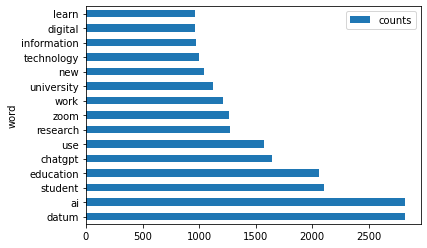

In [60]:
Lists=df.NoStopwords.to_list()

Lists=[i for i in Lists if i!=None]
Words=[item for sublist in Lists for item in sublist]

from collections import Counter
a_counter = Counter(Words)
most_common = a_counter.most_common(15)

print(most_common)#, most_common2)
pd.DataFrame.from_records(most_common,columns=["word","counts"],index="word").plot.barh()

# Finding the most hyping universities, articles, and sentences

In [85]:
# 1. Select Wordlist: here - from my hype library module (see Miller et al.)

WordLists=["predictive","imperative","subjunctive","hype_words","mod_words"] # Load from the hype module.

for wordList in WordLists:
    wordlist=hype.WordListDict[wordList]
    df[wordList+"_word"]=df.sentences.apply(hype.hype_word,keys=wordlist)
    df[wordList+"_sentence"]=df.sentences.apply(hype.hype_sentence,keys=wordlist)
    df[wordList+"_n"]=df[wordList+"_word"].apply(lambda x: len(x) if isinstance(x,list) else 0)
    
    print(f"\n ---> {wordList} <--- \n")
    
    example=df.sort_values(wordList+"_n", ascending=False).head()
    example[[wordList+"_word",wordList+"_n"]]
    
    for i in example[wordList+"_sentence"]:
        print(i)


df.head()

mod_words=df[df['mod_words_n']>0]




 ---> predictive <--- 

['Evaluation criteria Project proposals will be assessed on the following criteria: Expected returns from the project (50%) Does the problem exploration convincingly explain in which educational component a change is desired and why Does the applicant make a plausible case that the proposed innovation can lead to an improvement or a relevant yield (e. g. using relevant literature and examples from practice) Are the intended outputs, such as learning outcomes, vision formation or concrete products, clearly described Are the intended proceeds of added value for students and/or teachers Do they contribute to knowledge and vision formation on the use of AI Chatbots in education What is the scope of the project How many students, teachers, programmes, faculties are reached Does the applicant make a plausible case that the project could also be of interest to others, outside the consortium Quality of the project plan (50%) Are the activities, methods used and plannin


 ---> mod_words <--- 

["Still, students perceive the automatic grading in this study as fair and consistent with teacher expectations.29 What insights like these can lead to is the general discussion around educational technologies and AI, where historically, under-served and underrepresented populations, including ethnic/racial minorities and linguistic minorities are not well represented by these technologies' training data.30 Teachers implementing AI systems in their classrooms and lectures therefore have questions they should ask, such as: ------------ Teacher: Questions - Do all my students have access to a device and Internet connection to do their classwork  And also at home to do their homework - Who can I go to for support with a new system like Perusall - Do I agree with the grades this system is automatically giving What do I do if I disagree What changes in curriculum will have to happen to work with this platform  - How do I communicate to my students that an algorithm w

In [62]:
mod_words.to_json(analysis.Today+"GPT3_Subset_predictive.json")

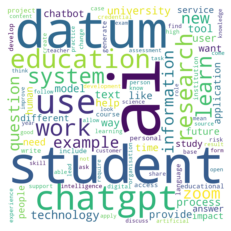

In [63]:
imp_words=df[df['predictive_n']>0]

WordList=imp_words.NoStopwords.to_list()
WordList=analysis.flat(WordList)
#WordList
analysis.make_wordcloud(WordList,filename="predictive.jpg")

W


<AxesSubplot: xlabel='date'>

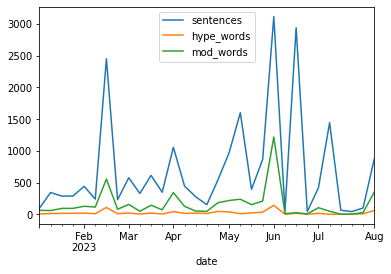

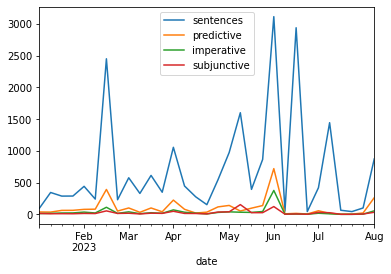

In [87]:
## Generate Timerows
print(freq)
hype_time=df.set_index("date").groupby(pd.Grouper(freq=freq))

timerows=df_publ
for l in WordLists:
    timerows[l]=hype_time[l+"_n"].apply(lambda x: sum(x) if len(x)>0 else 0)
    
timerows[["sentences","hype_words","mod_words"]][timerows.index>pd.Timestamp("2023-1-1")].plot()
timerows[["sentences","predictive","imperative","subjunctive"]][timerows.index>pd.Timestamp("2023-1-1")].plot()

In [88]:
timerows.fillna(0.000)
for c in timerows.columns[1:]:
    print(c)
    timerows[c+"-rel"]=timerows["sentences"]/timerows[c].fillna(0)

predictive
imperative
subjunctive
hype_words
mod_words


<AxesSubplot: xlabel='date'>

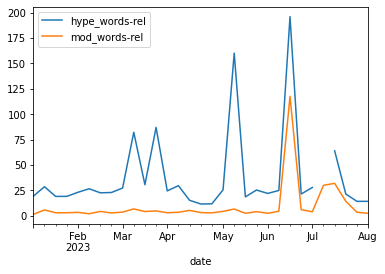

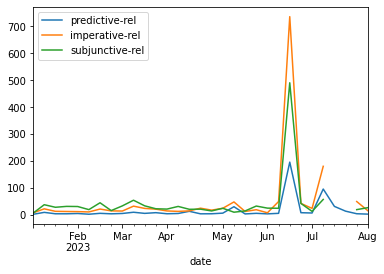

In [89]:
timerows[["hype_words-rel","mod_words-rel"]][timerows.index>pd.Timestamp(2023,1,1)].plot()
timerows[["predictive-rel","imperative-rel","subjunctive-rel"]][timerows.index>pd.Timestamp(2023,1,1)].plot()

In [147]:
timerows["hype_words"]

141

In [151]:
HypeMax=timerows[timerows["hype_words"]==timerows["hype_words"].max()]

HypeMaxDateTime=HypeMax.index[0]
HypeMax

,sentences,predictive,imperative,subjunctive,hype_words,mod_words,predictive-rel,imperative-rel,subjunctive-rel,hype_words-rel,mod_words-rel
date,,,,,,,,,,,
2023-06-04,3115,720,376,122,141,1218,4.326389,8.284574,25.532787,22.092199,2.557471


In [133]:
HypeMaxDateTime+ pd.DateOffset(7)

Timestamp('2023-06-11 00:00:00')

In [142]:
pd.set_option('display.max_colwidth', 400)

df[df.date>=HypeMax.index[0]][df.date<=HypeMaxDateTime+ pd.DateOffset(7)].filepath.drop_duplicates()

C:\Users\mr\AppData\Local\Temp\ipykernel_13584\2752584454.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.date>=HypeMax.index[0]][df.date<=HypeMaxDateTime+ pd.DateOffset(7)].filepath.drop_duplicates()


13140    C:\Users\mr\Zotero\storage\PVXYCB5E\workshop-creai-applying-ai-tools-in-the-creative-process-7-june.html
14950                          C:\Users\mr\Zotero\storage\VIMPSXE6\review-of-knowledge-sharing-education-365.html
Name: filepath, dtype: object

# Named entity recognition of hype / mod sentences

In [153]:
pd.set_option('display.max_colwidth', 400)

example=df.dropna(subset="mod_words_sentence").sort_values("hype_words_n", ascending=False)
example[["hype_words_n","sentences"]].head()

,hype_words_n,sentences
6720,3,"It is clear that as technologies hold the promise of significantly transforming our society in the years to come, we must learn how to use these to enjoy their advantages avoiding unwanted situations."
27594,3,"Users ask questions that are then passed through these models; the final output is then constructed as a greeting and then the relevant information from the syllabus.37 The virtual agent uses semantic information processing technology to reply to human-typed questions.38 Importantly, Jill Watson does not and cannot learn from student responses or feedback in their interactions with (outside) u..."
5489,3,"Can you discuss any particularly innovative or groundbreaking projects currently being undertaken at the centre One of the notable projects is the EUR Smart Campus Project , Opens external which aims to utilise data and digitalisation to create awareness around sustainability and human well-being."
5772,3,"This shift has offered the opportunity to expand and grow both research and educational practice in many novel directions, but in these increasingly self-directed learning environments the need for students to be able to effectively self-regulate their learning is more important than ever."
14035,2,AI can significantly help heritage institutions deliver on their missions.


In [165]:
import spacy
import spacy_transformers
NER = spacy.load("en_core_web_trf") # thanks to Martin L. for advising me on this.

RAW_text=" ".join(example.sentences.to_list()[:150])
text=NER(RAW_text)
Orgs=[word.text for word in text.ents if word.label_=="ORG"]

from collections import Counter
Counter(Orgs).most_common(20)

[('EUR', 5),
 ('ChatGPT', 3),
 ('WUR', 2),
 ('ChatLab', 2),
 ('EU', 2),
 ('the EUR Smart Campus Project', 1),
 ('IBM', 1),
 ('US Labor Bureau', 1),
 ('risico', 1),
 ('The Faculty Board’s', 1),
 ('University', 1),
 ('Van alle individueel significante', 1),
 ('Van individueel niet significante vorderingen', 1),
 ('de interne beheersing', 1),
 ('Erasmus Centre for Data Analytics..', 1),
 ('IS', 1),
 ('HOSA', 1),
 ('Cloudflare', 1),
 ('ELSA Labs', 1),
 ('Access', 1)]

In [156]:
Counter(Orgs).most_common(20)

[('AI', 691),
 ('Zoom', 56),
 ('EU', 47),
 ('GPT-3', 36),
 ('quantum', 24),
 ('EUR', 22),
 ('Utrecht University', 21),
 ('TU', 21),
 ('GPT', 19),
 ('Artificial Intelligence', 18),
 ('Education', 18),
 ('API', 16),
 ('Diagnostic Data', 15),
 ('Customer', 15),
 ('IAM', 14),
 ('XR', 13),
 ('SURF', 13),
 ('Domain Architecture for Identity & Access', 13),
 ('IBM', 12),
 ('Microsoft', 12)]

# Word dependency

In [155]:
import spacy
nlp = spacy.load("en_core_web_sm")


RAW_text=" ".join(example.sentences.to_list())
doc=nlp(RAW_text)

subjects=[]
subjects2=[]
objects=[]
verbs=[]
verbs2=[]
for token in doc:
    if token.dep_=="nsubj":
        subjects.append(token.lemma_)
        subjects2.append(", ".join([child.lemma_ for child in token.children])+" "+token.lemma_)
        
    if token.dep_=="pobj" or token.dep_=="dobj":
        objects.append(token.text)
        
    if token.dep_=="ROOT":
        verbs.append(token.text)
        SUB="you"
        if SUB in [child.lemma_ for child in token.children]:
            subj=" ".join([child.lemma_ for child in token.children if child.lemma_==SUB])
            obj=", ".join([child.text for child in token.children if child.dep_=="pobj" or child.dep_=="dobj"])
            verbs2.append(subj+ " " +token.text + " " + obj)
    


from collections import Counter
A=Counter(subjects2).most_common(20)

B=Counter(objects).most_common(20)

C=Counter(verbs).most_common(20)
print(A)
print(B)
print(C)

[(' we', 955), (' you', 790), (' it', 613), (' that', 495), (' they', 393), (' this', 250), (' I', 207), (' student', 174), (' who', 129), (' which', 121), (' Zoom', 111), (' ChatGPT', 102), (' AI', 89), (' what', 77), (' he', 70), (' user', 40), (' people', 40), ('the person', 36), ('the student', 35), (' chatgpt', 32)]
[('data', 346), ('AI', 268), ('ChatGPT', 234), ('education', 234), ('it', 210), ('students', 178), ('that', 157), ('example', 154), ('which', 153), ('information', 149), ('questions', 133), ('what', 129), ('use', 127), ('time', 122), ('this', 113), ('them', 107), ('systems', 103), ('work', 99), ('research', 98), ('way', 97)]
[('is', 420), ('be', 350), ('have', 169), ('need', 141), ('are', 106), ('used', 84), ('want', 84), ('use', 84), ('help', 51), ('means', 50), ('include', 48), ('provide', 48), ('take', 43), ('met', 42), ('says', 38), ('needs', 33), ('discuss', 32), ('make', 32), ('become', 32), ('know', 31)]


In [157]:
Counter(verbs2).most_common(30)

[('you have ', 17),
 ('you be ', 16),
 ('you need ', 12),
 ('you want ', 12),
 ('you Are ', 9),
 ('you know ', 8),
 ('you use ChatGPT', 6),
 ('you think ', 6),
 ('you are ', 5),
 ('you help you', 5),
 ('you like ', 5),
 ('you learn ', 5),
 ('you apply ', 4),
 ('you register ', 4),
 ('you expect ', 3),
 ('you consider ', 3),
 ('you see ', 3),
 ('you read more', 3),
 ('you work ', 3),
 ('you get ', 3),
 ('you use exams', 3),
 ('you reach ', 3),
 ('you find information', 3),
 ('you attend seminar', 3),
 ('you adapt module', 3),
 ('you have questions', 3),
 ('you decide ', 2),
 ('you challenge you', 2),
 ('you determine ', 2),
 ('you focus ', 2)]

<BarContainer object of 20 artists>

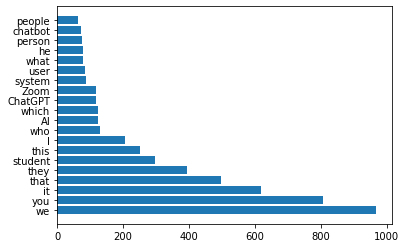

In [158]:
Subjects=[i for i in subjects2]
a,b=zip(*Counter(subjects).most_common(20))

from matplotlib import pyplot as plt
a
plt.barh(a, b)


In [ ]:
for token in subjects2:
    print(token)

# Hype-word & Mod-word statistics per university

In [32]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "mod_words":df.groupby("Uni").sum()["mod_words_n"]})

Counts["mean mod-words"]=Counts["mod_words"]/Counts["sentences"]

Counts.sort_values("mean mod-words", ascending=False)

KeyError: Index(['FileKey'], dtype='object')

In [ ]:
Counts=pd.DataFrame({"publications": df.drop_duplicates(subset="FileKey").value_counts("Uni"), 
                     "sentences":df.value_counts("Uni"),
                    "hype_words":df.groupby("Uni").sum()["hype_words_n"]})

Counts["mean hype_words"]=Counts["hype_words"]/Counts["sentences"]
Counts.sort_values("mean hype_words", ascending=False)

# Use of words over time

In [34]:
from collections import Counter


keyWords="chatgpt,education,chatbot,university,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"
keyWords="education,chatbot,create,write,produce,answer,tool,human,skill,knowledge,bias,assignment,intelligence,artificial,test,evaluate,assessment,plagiarism"

keyWords=keyWords.split(",")
print(keyWords)

group=df.set_index("date").groupby(pd.Grouper(freq='M'))["NoStopwords"].sum()

Wordyear={}
Wordyear_exact={}
Wordyear_only={}
for i, row in group.items():
    
    #print(i,row)
    if type(row)==list:
        
        ## filter ROW for interesting key-words:
        row=[i for i in row if i in keyWords]
        
        c=Counter(row).most_common(5)
        
        c_exact=[(i[0],i[1]/len(group)) for i in c]

        c=[(i[0],str(round(i[1]/len(group)*100,2))+"%") for i in c]
        c_only=[i[0] for i in c]


        Wordyear[str(i)]=c
        Wordyear_exact[str(i)]=c_exact
        Wordyear_only[str(i)]=c_only
        
        
        
    #print(c,"\n")
    
CountDF=pd.DataFrame.from_dict(Wordyear, orient='index').T


CountDF.T[CountDF.T.index>"2022-10-01"]

['education', 'chatbot', 'create', 'write', 'produce', 'answer', 'tool', 'human', 'skill', 'knowledge', 'bias', 'assignment', 'intelligence', 'artificial', 'test', 'evaluate', 'assessment', 'plagiarism']


,0,1,2,3,4
2022-10-31 00:00:00,"(knowledge, 2.36%)","(chatbot, 1.35%)","(artificial, 0.68%)","(intelligence, 0.68%)","(assessment, 0.68%)"
2022-11-30 00:00:00,"(chatbot, 2.03%)",None,None,None,None
2022-12-31 00:00:00,"(write, 12.84%)","(artificial, 5.74%)","(answer, 5.74%)","(intelligence, 5.41%)","(knowledge, 4.39%)"
2023-01-31 00:00:00,"(education, 45.27%)","(chatbot, 25.34%)","(write, 24.66%)","(intelligence, 23.65%)","(human, 22.64%)"
2023-02-28 00:00:00,"(education, 47.64%)","(intelligence, 32.43%)","(artificial, 26.35%)","(tool, 22.97%)","(write, 21.28%)"
2023-03-31 00:00:00,"(education, 70.61%)","(tool, 38.85%)","(write, 32.77%)","(answer, 31.08%)","(assessment, 28.04%)"
2023-04-30 00:00:00,"(education, 30.74%)","(human, 17.91%)","(write, 15.88%)","(intelligence, 14.53%)","(chatbot, 12.16%)"
2023-05-31 00:00:00,"(education, 45.61%)","(intelligence, 37.5%)","(artificial, 36.82%)","(tool, 30.74%)","(create, 19.59%)"
2023-06-30 00:00:00,"(education, 140.54%)","(create, 20.95%)","(knowledge, 16.22%)","(tool, 12.5%)","(intelligence, 12.16%)"
2023-07-31 00:00:00,"(education, 54.05%)","(human, 23.99%)","(intelligence, 19.59%)","(artificial, 16.55%)","(tool, 10.81%)"


In [35]:
CountDF=pd.DataFrame.from_dict(Wordyear_only, orient='index').T
CountDF.T[CountDF.T.index>"2022-10-01"]

,0,1,2,3,4
2022-10-31 00:00:00,knowledge,chatbot,artificial,intelligence,assessment
2022-11-30 00:00:00,chatbot,None,None,None,None
2022-12-31 00:00:00,write,artificial,answer,intelligence,knowledge
2023-01-31 00:00:00,education,chatbot,write,intelligence,human
2023-02-28 00:00:00,education,intelligence,artificial,tool,write
2023-03-31 00:00:00,education,tool,write,answer,assessment
2023-04-30 00:00:00,education,human,write,intelligence,chatbot
2023-05-31 00:00:00,education,intelligence,artificial,tool,create
2023-06-30 00:00:00,education,create,knowledge,tool,intelligence
2023-07-31 00:00:00,education,human,intelligence,artificial,tool


In [ ]:
#df=df.drop_duplicates("text_clean")

# Words in context & Word-Graph analysis

In [36]:
Result=df[df["sentences"].apply(lambda x: "Google" in x)]["sentences"].to_list()

[print(i, "\n") for i in Result]

’ Neem een zoekopdracht in Google, waarbij de gewenste pagina’s al verschijnen voordat je je vraag volledig hebt ingetypt. 

Het is namelijk zo handig dat Google alarm heeft geslagen en Microsoft het wil integreren in de zoekmachine Bing.. ChatGPT genereert alles wat je maar kan denken. 

Daan zou je bijvoorbeeld kunnen vragen: “Om wat voor pakket gaat het ” en dan kun je ofwel “Pakket binnen Nederland” selecteren ofwel “Pakket buiten Nederland” waarop dan weer wordt overgegaan tot een vervolgvraag.. Een indrukwekkendere vorm van interactie is echter dat men ook via een Google Home-speaker verbinding kan maken met Daan door te vragen “verbind mij met PostNL”. 

Google stuurt je dan door naar Daan, die wacht tot je wat tegen hem zegt. 

Meestal maakt de ontwikkelaar van een chatbot een grote verscheidenheid aan voorbeeldzinnen, waaronder gevallen met en zonder entiteiten, en een algoritme leert deze te koppelen (classificeren) aan de juiste bedoeling, door middel van “machine learning”.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
#This cell allows to read the words before and after a search_word. You can change the searchword & the size of the context.
@interact(search_word="education",words_before=(0,10),words_after=(0,10))
def text_context(column=["NoStopwords","sentences"],search_word="education",words_before=1,words_after=1):
    df[column].dropna().apply(analysis.Keyword_context,search_word=search_word.lower(),n_examples=1000,context=(words_before,words_after))


In [37]:
# WORD _GRAPH ANALYSIS

G=analysis.Word_NetworkGen(df,n=500,column="NoStopwords")
G2=analysis.CleanGraph(G,removeIsolates=True,minDegree=2,only_largest_component=True)
#G2=G
analysis.writeNetworkHTML(G2,view=False)
print("see the network: The_network.html")

[(('ai', 'ai'), 646), (('artificial', 'intelligence'), 574), (('personal', 'datum'), 461), (('datum', 'datum'), 457), (('ai', 'education'), 411)]
Cleaning Graph to minimum Degree 2.
Nodes count:  99
Edges count:  308
see the network: The_network.html


In [38]:
import networkx as nx
nx.write_gexf(G, "NoStopwords.gexf")

Centrality=pd.DataFrame(nx.closeness_centrality(G), index=[0]).T.sort_values(by=0,ascending=False)

Centrality.columns=["closeness-Centrality_per_sentence"]
Centrality.head(10)

,closeness-Centrality_per_sentence
ai,0.595930
education,0.520204
datum,0.503513
student,0.503513
research,0.495562
chatgpt,0.459302
science,0.457072
learn,0.454864
use,0.454864
new,0.446241


# Link Analysis 

In [39]:
import networkx as nx

df=pd.read_json("2023-06-06_Zotero_AI_nlp_en2.json")
links=df[["url","linkUrl"]].drop_duplicates(subset="url").explode("linkUrl")

In [40]:
def domain_From_url(url):
    if isinstance(url,str):
        domain=url.replace("https://","").replace("http://","").replace("www.","").split("/")[0].lstrip(".")
        domain=domain.rsplit("@",1)[-1].rsplit("%20",1)[-1]
        if domain.count(".")>1:
            domain=".".join(domain.rsplit(".",2)[-2:])

        if "." in domain:
            return domain
    
links["source"]=links.url.apply(domain_From_url)
links["target"]=links.linkUrl.apply(domain_From_url).reindex()

In [41]:
links=links.dropna(subset="target").dropna(subset="source")
links=links[~links["url"].apply(lambda x: "linkedin.com" in x)]
edgelist=(zip(links["source"], links["target"]))

links[links["source"]==None]
G = nx.from_edgelist(edgelist)
nx.write_gexf(G,"Links.gexf")
Link_Centrality=pd.DataFrame(nx.closeness_centrality(G),index=[0]).T.sort_values(ascending=False, by=0)
Link_Centrality.columns=["Centrality"]
Link_Centrality.head(10)

,Centrality
openai.com,0.436815
linkedin.com,0.418636
youtube.com,0.413075
facebook.com,0.410595
rug.nl,0.391782
twitter.com,0.388666
uu.nl,0.381300
uva.nl,0.375440
ru.nl,0.369358
tudelft.nl,0.368562


In [42]:
edgelist=(zip(links["source"], links["target"]))
edges=list(edgelist)

In [43]:
from collections import Counter
pd.DataFrame(Counter(edges).most_common(15))

,0,1
0,"(vu.nl, vu.nl)",229
1,"(tudelft.nl, tudelft.nl)",188
2,"(uu.nl, uu.nl)",171
3,"(utwente.nl, utwente.nl)",155
4,"(ru.nl, ru.nl)",128
5,"(tue.nl, tue.nl)",102
6,"(universiteitleiden.nl, universiteitleiden.nl)",92
7,"(wur.nl, wur.nl)",90
8,"(maastrichtuniversity.nl, maastrichtuniversity...",86
9,"(eur.nl, eur.nl)",72


In [44]:
links=df.linkUrl.to_list()
links=[list(set(l))for l in links if type(l)==list]
links=[i for s in links for i in s if i!=None]
domains=[domain_From_url(i) for s in links for i in s if i!=None]

In [45]:

from collections import Counter
a_counter = Counter(links)
most_common = a_counter.most_common(15)
most_common

[('https://www.youvisit.com/tour/vuamsterdam', 128),
 ('https://www.linkedin.com/school/vrije-universiteit-amsterdam/', 128),
 ('https://www.instagram.com/vuamsterdam/', 128),
 ('https://twitter.com/VUamsterdam', 128),
 ('https://www.facebook.com/vuamsterdam', 128),
 ('https://www.youtube.com/user/vrijeuniversiteit', 128),
 ('https://vu.nl/en/education/professionals', 119),
 ('https://vu.nl/en/about-vu/more-about/contact', 119),
 ('https://vu.nl/en/education/master', 119),
 ('https://vu.nl/en/education/bachelor', 119),
 ('https://studiegids.vu.nl/en', 119),
 ('https://vu.nl/en/alumni', 119),
 ('https://vu.nl/en/about-vu', 119),
 ('https://vu.nl/en/about-vu/more-about/vu-press-office', 119),
 ('https://vumagazine.nl/', 119)]

In [ ]:
links=df.linkUrl.to_list()